In [1]:
from datasets import load_dataset
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import os

import torch.optim as optim

import matplotlib.pyplot as plt

/home/aix7101/anaconda3/envs/j_knnee/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parameters

#-- setting custom model
total_l = 9
trans_l = 3
base_model = "google-bert/bert-base-uncased"
model_name = "sharmax-vikas/bert-base-banking77-pt2"

dataset_name = "PolyAI/banking77"

#-- setting result name
result_name = "banking_9_3"
model_save_path = f"/mnt/aix7101/jeong/ee/{result_name}.pt"

#-- setting training
train_strategy = "low_lr"  # 'freeze', 'low_lr', 'unfreeze'
num_epoch = 10
num_unfreeze = 3 

In [3]:
db = load_dataset(dataset_name)

Generating test split: 100%|██████████| 3080/3080 [00:00<00:00, 54663.25 examples/s]


In [4]:
print(db)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [5]:
# load train dataset
train_dataset = load_dataset(dataset_name, split="train")

# load validation dataset
val_dataset = load_dataset(dataset_name, split="test")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout = nn.Dropout(p=0.1).to(device) # in BERT default 0.1

In [7]:
# setting
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).eval().to(device)

In [8]:
from tqdm import tqdm
from sklearn.metrics import f1_score

correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()

for batch in tqdm(val_dataset):
    with torch.no_grad():
        # Tokenize single sample
        inputs = tokenizer(batch["text"], return_tensors="pt", padding=True, truncation=True).to(device)
        label = torch.tensor(batch["label"]).to(device)

        # Predict
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()

        # Accuracy
        correct += int(pred == label.item())
        total += 1

        # F1 계산용 저장
        all_preds.append(pred)
        all_labels.append(label.item())

# Accuracy
acc = correct / total * 100

# F1 Score (macro 방식 추천 - 다중 클래스일 때)
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"✅ Accuracy: {acc:.2f}%")
print(f"✅ F1 Score (macro): {f1:.4f}")

100%|██████████| 3080/3080 [00:20<00:00, 153.12it/s]

✅ Accuracy: 93.64%
✅ F1 Score (macro): 0.9365


## Custom model

In [9]:
from transformers import BertModel, BertConfig, BertForSequenceClassification
import torch.nn as nn
import torch

class CustomBertSmall(nn.Module):
    def __init__(self, teacher_model, total_layers=6, transplanted_layers=3):
        super().__init__()
        assert transplanted_layers < total_layers, "Transplanted layers must be fewer than total layers"
        
        self.hidden_size = teacher_model.config.hidden_size
        self.total_layers = total_layers
        self.transplanted_layers = transplanted_layers

        # 그대로 복사할 레이어 인덱스 계산
        transplanted_start = 12 - transplanted_layers
        original_layer_indices = list(range(transplanted_start))[:total_layers - transplanted_layers]

        # Embedding 복사
        self.embeddings = teacher_model.bert.embeddings

        # 선택된 layer만 복사해서 재구성
        self.encoder_layers = nn.ModuleList()

        for idx in original_layer_indices:
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        for idx in range(transplanted_start, 12):
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        # Pooler와 Classifier도 복사
        self.pooler = teacher_model.bert.pooler
        self.dropout = teacher_model.dropout  # from classifier head
        self.classifier = teacher_model.classifier

        self.activation = nn.Tanh()  # 여전히 pooler 내부에서도 사용되지만 보존

    # CustomBertSmall에 hidden_states 옵션 추가
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, output_hidden_states=False):
        hidden_states = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

        if attention_mask is not None:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        else:
            extended_attention_mask = None

        all_hidden = []  # 각 레이어 출력 저장
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, attention_mask=extended_attention_mask)[0]
            if output_hidden_states:
                all_hidden.append(hidden_states)

        pooled_output = self.pooler(hidden_states)
        pooled_output = self.dropout(self.activation(pooled_output))
        logits = self.classifier(pooled_output)

        if output_hidden_states:
            return logits, all_hidden
        else:
            return logits

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = "textattack/bert-base-uncased-ag-news"

teacher_model = BertForSequenceClassification.from_pretrained(base_model, num_labels=77,)

small_model = CustomBertSmall(
    teacher_model=teacher_model,
    total_layers=total_l,
    transplanted_layers=trans_l,  # 마지막 l개 레이어 복사
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## [check] before training

In [11]:
from sklearn.metrics import f1_score
from tqdm import tqdm

# Accuracy 카운터
correct_base = 0
correct_small = 0

# F1 계산용 리스트
base_preds = []
small_preds = []
all_labels = []

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model"):
    text = item["text"]
    label = item["label"]

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        # BERT-base
        output = model(**inputs)
        logits = output.logits
        pred = torch.argmax(logits, dim=-1).item()

        # Small model
        small_logits = small_model(**inputs)
        small_pred = torch.argmax(small_logits, dim=-1).item()

    correct_base += int(pred == label)
    correct_small += int(small_pred == label)

    # F1 계산용 저장
    base_preds.append(pred)
    small_preds.append(small_pred)
    all_labels.append(label)

# Accuracy
total = len(val_dataset)
acc_base = correct_base / total * 100
acc_small = correct_small / total * 100

# F1 Score (macro 방식 추천)
f1_base = f1_score(all_labels, base_preds, average="macro")
f1_small = f1_score(all_labels, small_preds, average="macro")

# 출력
print(f"\n✅ Accuracy of BERT-base: {acc_base:.2f}%")
print(f"✅ F1 Score of BERT-base: {f1_base:.4f}")

print(f"\n✅ Accuracy of CustomBertSmall: {acc_small:.2f}%")
print(f"✅ F1 Score of CustomBertSmall: {f1_small:.4f}")

Evaluating Small Model: 100%|██████████| 3080/3080 [00:34<00:00, 89.86it/s]


✅ Accuracy of BERT-base: 93.64%
✅ F1 Score of BERT-base: 0.9365

✅ Accuracy of CustomBertSmall: 1.43%
✅ F1 Score of CustomBertSmall: 0.0011


## Custom Loss

In [12]:
import torch.nn.functional as F
from torch.nn import MSELoss, KLDivLoss

def loss1(logits, labels):
    return F.cross_entropy(logits, labels)

# Representation Matching Loss (MSE between CLS tokens)
def loss2(student_hidden, teacher_hidden):
    mse = MSELoss()
    return mse(student_hidden, teacher_hidden)

# DSR Loss (KL Divergence between sorted logits)
def loss3(prev_logits, current_logits, tau=1.0):
    z_prev = torch.sort(prev_logits, dim=-1)[0]
    z_current = torch.sort(current_logits, dim=-1)[0]

    p_prev = F.softmax(z_prev / tau, dim=-1)
    p_current = F.log_softmax(z_current / tau, dim=-1)

    kldiv = KLDivLoss(reduction='batchmean')
    return (tau ** 2 / 2) * kldiv(p_current, p_prev)  # KL(p_prev || p_current)

In [13]:
import torch
import torch.nn.functional as F

def compute_cka(X: torch.Tensor, Y: torch.Tensor, eps=1e-8):
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)

    dot_product_similarity = (X.T @ Y).norm(p='fro') ** 2
    normalization_x = (X.T @ X).norm(p='fro')
    normalization_y = (Y.T @ Y).norm(p='fro')
    return dot_product_similarity / (normalization_x * normalization_y + eps)

def cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft):
    delta_t = h_teacher_aft - h_teacher_bef
    delta_s = h_student_aft - h_student_bef
    t = delta_t[:, 0, :]  # CLS
    s = delta_s[:, 0, :]
    return 1 - compute_cka(t, s)

## Train

In [14]:
def evaluate(model, val_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            text = batch["text"][0]
            label = batch["label"].item()

            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
            logits = model(**inputs)
            pred = torch.argmax(logits, dim=-1).item()

            correct += int(pred == label)
            total += 1

    return correct / total * 100

In [15]:
# import torch

# labels = torch.tensor(train_dataset["label"])
# print("Label dtype:", labels.dtype)
# print("Label min:", labels.min().item())
# print("Label max:", labels.max().item())

In [16]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW

def train_custom_model(
    model,
    train_dataset,
    val_dataset,
    tokenizer,
    teacher_model=None,  # 👈 custom loss를 쓸 경우 필요
    custom_loss=False,   # 👈 Loss type 선택
    strategy="freeze",
    batch_size=16,
    epochs=10,
    base_lr=5e-5,
    low_lr=5e-6,
    k=3,
    alpha=0.3,           # 👈 custom loss 비중
    unfreeze_epoch=1,
    save_path="best_model.pt",
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model = model.to(device)
    if custom_loss and teacher_model is None:
        raise ValueError("teacher_model must be provided when using custom_loss=True")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    if strategy == "low_lr":
        optimizer_grouped = [
            {"params": [p for l in model.encoder_layers[:-k] for p in l.parameters()], "lr": base_lr},
            {"params": [p for l in model.encoder_layers[-k:] for p in l.parameters()], "lr": low_lr},
            {"params": model.pooler.parameters(), "lr": base_lr},
            {"params": model.classifier.parameters(), "lr": base_lr},
        ]
    else:
        optimizer_grouped = model.parameters()

    optimizer = AdamW(optimizer_grouped, lr=base_lr)
    loss_fn = nn.CrossEntropyLoss()

    if strategy == "freeze":
        for layer in model.encoder_layers[-k:]:
            for param in layer.parameters():
                param.requires_grad = False
        ##-- freeze first layer
        # for param in model.encoder_layers[0].parameters():
        #     param.requires_grad = False

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{epochs}")

        if strategy == "unfreeze" and epoch == unfreeze_epoch:
            print("--<Unfreezing last K layers>--")
            for layer in model.encoder_layers[-k:]:
                for param in layer.parameters():
                    param.requires_grad = True

        for batch in tqdm(train_loader, desc="Training"):
            texts = batch["text"]
            labels = batch["label"]

            tokenized = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in tokenized.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            if custom_loss:
                # ----> Custom Loss: CE + CKA delta loss
                logits_small, student_hiddens = model(**inputs, output_hidden_states=True)
                ce_loss = loss_fn(logits_small, labels)

                with torch.no_grad():
                    teacher_outputs = teacher_model(**inputs, output_hidden_states=True)
                    h_teacher_bef = teacher_outputs.hidden_states[(-1)-(k+1)]
                    h_teacher_aft = teacher_outputs.hidden_states[(-1)-k]

                h_student_bef = student_hiddens[(-1)-(k+1)]
                h_student_aft = student_hiddens[(-1)-k]

                cka_loss = cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft)
                loss = ce_loss + alpha * cka_loss
            else:
                # ----> 기본 CE Loss만 사용
                logits = model(**inputs)
                loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Avg Training Loss: {avg_loss:.4f}")

        acc = evaluate(model, val_loader, tokenizer, device)
        print(f"Validation Accuracy: {acc:.2f}%")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved with accuracy: {best_acc:.2f}% → {save_path}")

In [17]:
train_custom_model(
    model=small_model,
    teacher_model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    custom_loss=True,              # ✅ 사용
    alpha=0.3,                     # CKA 가중치
    k=trans_l,
    strategy="train_strategy",
    unfreeze_epoch=num_unfreeze,
    epochs=num_epoch,
    save_path=model_save_path
)


Epoch 1/10


Training: 100%|██████████| 626/626 [00:32<00:00, 19.08it/s]


Avg Training Loss: 2.3174


Evaluating: 100%|██████████| 3080/3080 [00:15<00:00, 200.44it/s]


Validation Accuracy: 83.96%
✅ New best model saved with accuracy: 83.96% → /mnt/aix7101/jeong/ee/banking_9_3.pt

Epoch 2/10


Training: 100%|██████████| 626/626 [00:32<00:00, 19.47it/s]


Avg Training Loss: 0.5533


Evaluating: 100%|██████████| 3080/3080 [00:15<00:00, 197.15it/s]


Validation Accuracy: 91.30%
✅ New best model saved with accuracy: 91.30% → /mnt/aix7101/jeong/ee/banking_9_3.pt

Epoch 3/10


Training: 100%|██████████| 626/626 [00:33<00:00, 18.56it/s]


Avg Training Loss: 0.2638


Evaluating: 100%|██████████| 3080/3080 [00:16<00:00, 191.20it/s]


Validation Accuracy: 91.43%
✅ New best model saved with accuracy: 91.43% → /mnt/aix7101/jeong/ee/banking_9_3.pt

Epoch 4/10


Training: 100%|██████████| 626/626 [00:31<00:00, 19.66it/s]


Avg Training Loss: 0.1624


Evaluating: 100%|██████████| 3080/3080 [00:15<00:00, 194.83it/s]


Validation Accuracy: 90.88%

Epoch 5/10


Training: 100%|██████████| 626/626 [00:31<00:00, 19.83it/s]


Avg Training Loss: 0.1120


Evaluating: 100%|██████████| 3080/3080 [00:16<00:00, 185.31it/s]


Validation Accuracy: 90.84%

Epoch 6/10


Training: 100%|██████████| 626/626 [00:32<00:00, 19.13it/s]


Avg Training Loss: 0.0959


Evaluating: 100%|██████████| 3080/3080 [00:16<00:00, 187.41it/s]


Validation Accuracy: 91.69%
✅ New best model saved with accuracy: 91.69% → /mnt/aix7101/jeong/ee/banking_9_3.pt

Epoch 7/10


Training: 100%|██████████| 626/626 [00:32<00:00, 19.09it/s]


Avg Training Loss: 0.0666


Evaluating: 100%|██████████| 3080/3080 [00:16<00:00, 187.78it/s]


Validation Accuracy: 91.59%

Epoch 8/10


Training: 100%|██████████| 626/626 [00:33<00:00, 18.95it/s]


Avg Training Loss: 0.0754


Evaluating: 100%|██████████| 3080/3080 [00:16<00:00, 185.60it/s]


Validation Accuracy: 90.84%

Epoch 9/10


Training: 100%|██████████| 626/626 [00:33<00:00, 18.78it/s]


Avg Training Loss: 0.0793


Evaluating: 100%|██████████| 3080/3080 [00:16<00:00, 186.87it/s]


Validation Accuracy: 91.10%

Epoch 10/10


Training: 100%|██████████| 626/626 [00:33<00:00, 18.87it/s]


Avg Training Loss: 0.0508


Evaluating: 100%|██████████| 3080/3080 [00:16<00:00, 185.49it/s]


Validation Accuracy: 91.75%
✅ New best model saved with accuracy: 91.75% → /mnt/aix7101/jeong/ee/banking_9_3.pt


In [18]:
# # 학습 시작
# train_custom_model(
#     model=small_model,
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     tokenizer=tokenizer,
#     strategy=train_strategy,  # 'freeze', 'low_lr', 'unfreeze'
#     epochs=num_epoch,
#     batch_size=16,
#     base_lr=5e-5,
#     low_lr=5e-6,
#     k=2,  # 마지막 3개 레이어를 보존
#     unfreeze_epoch=num_unfreeze,
#     save_path=model_save_path
# )

## [check] after training

In [19]:
# load model

small_model.load_state_dict(torch.load(model_save_path, map_location=device))
small_model = small_model.eval().to(device)


In [20]:
# for accuracy with small model
correct_base = 0
correct_small = 0

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model"):
    text = item["text"]
    label = item["label"]

    # inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    # Teacher model (BertForSequenceClassification)
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits  # SequenceClassifierOutput에서 logits 추출
        pred = torch.argmax(logits, dim=-1).item()

    # Small model (CustomBertSmall)
    with torch.no_grad():
        small_logits = small_model(**inputs)  # 직접 logits 반환
        small_pred = torch.argmax(small_logits, dim=-1).item()
    
    correct_base += int(pred==label)
    correct_small += int(small_pred == label)

# 정확도 출력
total = len(val_dataset)
print(f"\n✅ Accuracy of Bertbase: {correct_base / total * 100:.2f}%")
print(f"\n✅ Accuracy of CustomBertSmall: {correct_small / total * 100:.2f}%")

Evaluating Small Model: 100%|██████████| 3080/3080 [00:36<00:00, 84.50it/s]


✅ Accuracy of Bertbase: 93.64%

✅ Accuracy of CustomBertSmall: 91.75%


In [21]:
# 정확도 저장 리스트
acc_original = []
acc_small = [0] * total_l  # ✅ small_model의 레이어 수만큼 정확도 저장

for layer in range(1, 13):  # BERT-base: layer 1~12
    correct_orig = 0
    correct_small_by_layer = [0] * total_l  # 각 small layer의 정답 수
    total = 0

    for item in tqdm(val_dataset, desc=f"Layer {layer}"):
        text = item["text"]
        label = item["label"]
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            # BERT-base layer별 정확도
            outputs = model(**inputs)
            hidden = outputs.hidden_states[layer]
            pooled = model.bert.pooler(hidden)
            pooled_dropped = dropout(pooled)
            logits_orig = model.classifier(pooled_dropped)
            pred_orig = torch.argmax(logits_orig).item()

            # small model: 전체 forward + hidden states
            logits_small, small_hidden_states = small_model(**inputs, output_hidden_states=True)

            for i, h in enumerate(small_hidden_states):
                pooled_small = small_model.pooler(h)  # CLS 포함
                pooled_small = dropout(pooled_small)
                logits = small_model.classifier(pooled_small)
                pred = torch.argmax(logits, dim=-1).item()
                correct_small_by_layer[i] += int(pred == label)

            correct_orig += int(pred_orig == label)
            total += 1

    acc_original.append(correct_orig / total)

    # 마지막 layer 기준에서 정확도 누적 (1 epoch 끝났을 때만 기록됨)
    if layer == 12:
        acc_small = [c / total for c in correct_small_by_layer]

Layer 12: 100%|██████████| 3080/3080 [00:40<00:00, 75.36it/s]


In [22]:
acc_original

[0.013636363636363636,
 0.013636363636363636,
 0.013636363636363636,
 0.01396103896103896,
 0.01525974025974026,
 0.016558441558441557,
 0.05357142857142857,
 0.05032467532467533,
 0.16103896103896104,
 0.6087662337662337,
 0.9019480519480519,
 0.937987012987013]

In [23]:
acc_small

[0.013636363636363636,
 0.01525974025974026,
 0.009415584415584415,
 0.016233766233766232,
 0.05551948051948052,
 0.17597402597402598,
 0.7204545454545455,
 0.8944805194805194,
 0.9178571428571428]

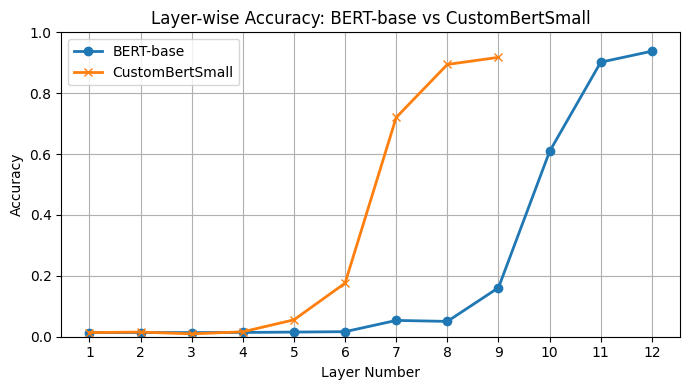

In [24]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 13), acc_original, label="BERT-base", marker='o', linewidth=2)
plt.plot(range(1, total_l + 1), acc_small, label="CustomBertSmall", marker='x', linewidth=2)
plt.xlabel("Layer Number")
plt.ylabel("Accuracy")
plt.title("Layer-wise Accuracy: BERT-base vs CustomBertSmall")
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig(f"img/{result_name}.png", dpi=300)
plt.show()